# **Notebook Instructions**
Please make a copy of this notebook before making any changes :)

Files needed: 
*   latent_ori.pt - contains latent space of 45,000 city layouts
*   city_layouts.csv - contains the coordinates, train_index and clustering results of 45,000 city layouts
*   results.csv - contains the human scoring of city layout similarity



## **Set up**

In [1]:
!pip install geopandas
import glob
import math
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
import copy
import time
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('../')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

from matplotlib import pyplot as plt
# import seaborn as sns
# sns.set_theme()
import matplotlib.patches as patches
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry.polygon import Point, Polygon
matplotlib_axes_logger.setLevel('ERROR')

     |████████████████████████████████| 994 kB 4.2 MB/s 
     |████████████████████████████████| 15.4 MB 64 kB/s 
     |████████████████████████████████| 6.6 MB 42.2 MB/s 


In [2]:
# load required files
path = 'city_layout_analysis/'
latent_ori = torch.load(path+'latent_ori.pt')
city_layouts = pd.read_csv(path+'city_layouts.csv',index_col=0)
results = pd.read_csv(path+'results.csv',header=None)

In [3]:
def inference_final_set(P, F, n, out=[]):
    '''
    Input:
        P: Positions of initial node  n*3
        F: Features of initial node  n*d
        n: Max level of generated tree
    Output:
        out: Position List of generated children nodes
    ''' 
    if(n == 0):
        return out
    P_list = []
    P_list_re = []
    I_list = []
    leaf_node_list = []
    
    tmp_P = P
    tmp_F = F
    father_I = torch.zeros((1,1))
    P_list.append(P[0])

    for i in range(n):
        left_featrue, left_P, left_isleaf, right_featrue, right_P, right_isleaf = model.decoder(tmp_F, tmp_P)
        
        left_xy_new = left_P[:,:2] * tmp_P[:,2:4] + tmp_P[:,:2]
        left_P[:,:2] = left_xy_new
        left_wh_new = left_P[:,2:4] * tmp_P[:,2:4]
        left_P[:,2:4] = left_wh_new
        left_a_new = left_P[:,4] + tmp_P[:,4]
        left_P[:,4] = left_a_new
        
        right_xy_new = right_P[:,:2] * tmp_P[:,2:4] + tmp_P[:,:2]
        right_P[:,:2] = right_xy_new
        right_wh_new = right_P[:,2:4] * tmp_P[:,2:4]
        right_P[:,2:4] = right_wh_new
        right_a_new = right_P[:,4] + tmp_P[:,4]
        right_P[:,4] = right_a_new
        
        I = np.zeros(len(left_P)*2, dtype='int32')
        
        temp_I_list = []
        left_node_index = torch.zeros((len(left_P),1))
        right_node_index = torch.zeros((len(right_P),1))
        
        for j in range(len(left_P)):
            
            P_list.append(left_P[j])
            left_index =len(P_list) -1
            P_list.append(right_P[j])
            right_index =len(P_list) -1
            
            father_index = father_I[j].detach().numpy()
            father_index = int(father_index)
            temp_I = [left_index, right_index, father_index]
            
            I[2*j] = left_index
            I[2*j+1] = right_index
            left_node_index[j] = left_index
            right_node_index[j] = right_index

            temp_I_list.append(temp_I)
            
        if(temp_I_list):     
            I_list.append(temp_I_list) 
    
        tmp_F = []
        tmp_P = []
        father_I = []
        
        left_isleaf = torch.round(left_isleaf)[:,0]
        right_isleaf = torch.round(right_isleaf)[:,0]
        
        tmp_F.append(left_featrue[left_isleaf==0,:])
        tmp_P.append(left_P[left_isleaf==0,:])
        father_I.append(left_node_index[left_isleaf==0,:])
        
        tmp_F.append(right_featrue[right_isleaf==0,:])
        tmp_P.append(right_P[right_isleaf==0,:])
        father_I.append(right_node_index[right_isleaf==0,:])
        
        if(len(left_P[left_isleaf==1,:])>0):
            leaf_node_list.append(left_P[left_isleaf==1,:])
        if(len(right_P[right_isleaf==1,:])>0):
            leaf_node_list.append(right_P[right_isleaf==1,:])
        
        tmp_F = torch.cat(tmp_F, 0)
        tmp_P = torch.cat(tmp_P, 0)
        father_I = torch.cat(father_I, 0)

    P_list = torch.stack(P_list)
    leaf_node_list = torch.cat(leaf_node_list)
    return P_list, I_list, leaf_node_list

def rotate_xy_2(p, sin, cos, center):
    x_ = (p[:,0:1]-center[:,0:1])*cos-(p[:,1:2]-center[:,1:2])*sin+center[:,0:1]
    y_ = (p[:,0:1]-center[:,0:1])*sin+(p[:,1:2]-center[:,1:2])*cos+center[:,1:2]
    return np.hstack((x_, y_))

def get_box_2(P, F):
    ld = np.hstack((P[:,0:1]-F[:,0:1]/2, P[:,1:2]-F[:,1:2]/2))
    rd = np.hstack((P[:,0:1]+F[:,0:1]/2, P[:,1:2]-F[:,1:2]/2))
    ru = np.hstack((P[:,0:1]+F[:,0:1]/2, P[:,1:2]+F[:,1:2]/2))
    lu = np.hstack((P[:,0:1]-F[:,0:1]/2, P[:,1:2]+F[:,1:2]/2))
    sinO = np.sin(F[:,2:3])
    cosO = np.cos(F[:,2:3])

    ld_r = rotate_xy_2(ld, sinO, cosO, P)
    rd_r = rotate_xy_2(rd, sinO, cosO, P)
    ru_r = rotate_xy_2(ru, sinO, cosO, P)
    lu_r = rotate_xy_2(lu, sinO, cosO, P)
    if(len(P)>0):
        box_r = np.hstack((ld_r, rd_r, ru_r, lu_r)).reshape(len(P), -1, 2)
    else:
        box_r = []
    return box_r

def plot_boxes2(samples, n, m, A, B):
    fig = plt.figure(figsize=(5*m,5*n))
    fig.set_tight_layout(True)
    for i in range(n):
        for j in range(m):
            idx = i * m + j
            ax = fig.add_subplot(n, m, idx+1)
            draw_box2(samples[idx])  
    plt.savefig('combi_interpolation/{}_{}.png'.format(A,B),dpi=500)
    plt.show()

def plot_boxes3(samples, n, A, B):
    for idx in range(n):
        for i, pc in enumerate(samples[idx]):
            X, Y= pc[:, 0], pc[:,1]
            plt.plot(X, Y, c='b')
            plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c='b')
            plt.axis('equal')            
        plt.savefig('latent_interpolation/{}_{}_{}.png'.format(A, B, idx),dpi=300,pad_inches=0.0)
        plt.show()

def draw_polygon_c(pc, txt, center, color):
    X, Y= pc[:, 0], pc[:,1]
    plt.plot(X, Y, c=color)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c=color)
    plt.axis('off')

def draw_box(box, txt, center, color):
    for i, p in enumerate(box):
        c = 'r' if color[i] else 'b'
        draw_polygon_c(p, txt[i], center[i], c)

def draw_box2(box):
    for i, p in enumerate(box):
        draw_polygon_c2(p)

def plot_boxes(samples, label, center, color, n, m, index):
    fig = plt.figure(figsize=(5*m,5*n))
    fig.set_tight_layout(True)
    for i in range(n):
        for j in range(m):
            idx = i * m + j
            ax = fig.add_subplot(n, m, idx+1)
            draw_box(samples[idx], label[idx], center[idx], color[idx])  
    plt.savefig('indiv_layouts/{}'.format(index))
    plt.show()

def draw_polygon_c2(pc, color='b'):
    X, Y= pc[:, 0], pc[:,1]
    plt.plot(X, Y, c=color)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c=color)
    plt.axis('equal')

def draw_polygon_s(pc, w, c):
    
    X, Y= pc[:, 0], pc[:,1]
    plt.plot(X, Y, linewidth=w, color=c)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], linewidth =w, color=c)
    plt.axis('equal')
    plt.axis('off')

def draw_box_save(box, linewidth='3', color='mediumslateblue', name='gt'): 
    fig = plt.figure(figsize=(6,6))
    for i, p in enumerate(box):
        draw_polygon_s(p, linewidth, color)
    plt.savefig(name,bbox_inches='tight',dpi=300,pad_inches=0.0)

In [4]:
import model_ae_tree_box_ab2_new_re_weight_lstm_print
from model_ae_tree_box_ab2_new_re_weight_lstm_print import *

trainset = TreeData(data_folder="32boxes_coordinates.pickle", train=True, split=1, n_feature=512, num_box=32, batch_size=50)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)

model = AE.load_from_drive(AE, name=path+'tree_lstm_64_test_32box_2_best', model_dir='', device=torch.device('cuda'), n_feature=512)

In [5]:
all_features = {}
for i,v in enumerate(train_loader, 0):
    all_features[i] = v

In [6]:
def plot_box(train_index, idx):

  batch = train_index//50
  batch_num = train_index%50
  
  X, I_list, Feature, Node_is_leaf = all_features[batch]

  X = X.squeeze(0)
  Feature = Feature.squeeze(0)
  Node_is_leaf = Node_is_leaf.squeeze(0)
  X = X.float()
  Feature = Feature.float()

  Feature_New = model.encode(X, Feature, I_list)
  X_r, X_ab_xy, X_ab_xy_r, Feature_r, Loss_P, Loss_Leaf, Num, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)
  X_ab_xy = X_ab_xy.detach().numpy()

  N = 32 #change num_boxes
  N_total = 2*N-1
  X_tree0 = X_ab_xy[N_total*batch_num:N_total*(batch_num+1),:2]
  Feature_tree0 = X_ab_xy[N_total*batch_num:N_total*(batch_num+1),2:]

  box_list = []
  center_list = []
  txt_list = []
  color_list = []

  node_index = np.arange(N)
  color = np.zeros(len(node_index))
  P = X_tree0[node_index,:2]
  F = Feature_tree0[node_index]
  box = get_box_2(P,F)
  box_list.append(box)
  center_list.append(P)
  txt_list.append(node_index)
  color_list.append(color)  

  plot_boxes(box_list, txt_list, center_list, color_list, 1, 1, idx)

##**Downloading dataset | Do not run**
This code generates and extracts the latent space for 45,000 buildings, using the AETree encoder. Split into several cells as the process is memory intensive. This can be ignored if you already have the latent_ori.pt file.


In [ ]:
import model_ae_tree_box_ab2_new_re_weight_lstm_print
from model_ae_tree_box_ab2_new_re_weight_lstm_print import *

trainset = TreeData(data_folder="32boxes_coordinates.pickle", train=True, split=1, n_feature=512, num_box=32, batch_size=50)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)

model = AE.load_from_drive(AE, name=path+'tree_lstm_64_test_32box_2_best', model_dir='', device=torch.device('cuda'), n_feature=512)

In [ ]:
root_F_list = []
root_P_list = []

Batch = 50
N = 32
s = 2*N-2
e = 2*N-1
a = 0

for i,(X, I_list, Feature, Node_is_leaf) in enumerate(train_loader, 0):
    X = X.squeeze(0)
    Feature = Feature.squeeze(0)
    Node_is_leaf = Node_is_leaf.squeeze(0)
    X = X.float()
    Feature = Feature.float()

    Feature_New = model.encode(X, Feature, I_list)
    _, _, X_ab_xy_r, Feature_r, _, _, _, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)

    for j in range(Batch):
        # root_F = Feature_r[s+j*e:e+j*e]
        # root_F_list.append(root_F)
        
        root_P = X_ab_xy_r[s+j*e:e+j*e]
        root_P_list.append(root_P)

    if i == 149:
      break

latents = torch.cat(root_P_list, dim=0).detach().numpy()
latent_ori = torch.from_numpy(latents).contiguous().float()

In [ ]:
root_F_list = []
root_P_list = []

for i,(X, I_list, Feature, Node_is_leaf) in enumerate(train_loader, 0):
  if i>149:
    X = X.squeeze(0)
    Feature = Feature.squeeze(0)
    Node_is_leaf = Node_is_leaf.squeeze(0)
    X = X.float()
    Feature = Feature.float()

    Feature_New = model.encode(X, Feature, I_list)
    _, _, X_ab_xy_r, Feature_r, _, _, _, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)

    for j in range(Batch):
        # root_F = Feature_r[s+j*e:e+j*e]
        # root_F_list.append(root_F)

        root_P = X_ab_xy_r[s+j*e:e+j*e]
        root_P_list.append(root_P)

    if i == 299:
      break

latents = torch.cat(root_P_list, dim=0).detach().numpy()
next_latent_ori = torch.from_numpy(latents).contiguous().float()
latent_ori = torch.cat((latent_ori,next_latent_ori),dim=0)

In [ ]:
root_F_list = []
root_P_list = []

for i,(X, I_list, Feature, Node_is_leaf) in enumerate(train_loader, 0):
  if i>299:
    X = X.squeeze(0)
    Feature = Feature.squeeze(0)
    Node_is_leaf = Node_is_leaf.squeeze(0)
    X = X.float()
    Feature = Feature.float()

    Feature_New = model.encode(X, Feature, I_list)
    _, _, X_ab_xy_r, Feature_r, _, _, _, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)

    for j in range(Batch):
        # root_F = Feature_r[s+j*e:e+j*e]
        # root_F_list.append(root_F)

        root_P = X_ab_xy_r[s+j*e:e+j*e]
        root_P_list.append(root_P)

    if i == 449:
      break

latents = torch.cat(root_P_list, dim=0).detach().numpy()
next_latent_ori = torch.from_numpy(latents).contiguous().float()
latent_ori = torch.cat((latent_ori,next_latent_ori),dim=0)

In [ ]:
root_F_list = []
root_P_list = []

for i,(X, I_list, Feature, Node_is_leaf) in enumerate(train_loader, 0):
  if i>449:
    X = X.squeeze(0)
    Feature = Feature.squeeze(0)
    Node_is_leaf = Node_is_leaf.squeeze(0)
    X = X.float()
    Feature = Feature.float()

    Feature_New = model.encode(X, Feature, I_list)
    _, _, X_ab_xy_r, Feature_r, _, _, _, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)

    for j in range(Batch):
        # root_F = Feature_r[s+j*e:e+j*e]
        # root_F_list.append(root_F)

        root_P = X_ab_xy_r[s+j*e:e+j*e]
        root_P_list.append(root_P)

    if i == 599:
      break

latents = torch.cat(root_P_list, dim=0).detach().numpy()
next_latent_ori = torch.from_numpy(latents).contiguous().float()
latent_ori = torch.cat((latent_ori,next_latent_ori),dim=0)

In [ ]:
root_F_list = []
root_P_list = []

for i,(X, I_list, Feature, Node_is_leaf) in enumerate(train_loader, 0):
  if i>599:
    X = X.squeeze(0)
    Feature = Feature.squeeze(0)
    Node_is_leaf = Node_is_leaf.squeeze(0)
    X = X.float()
    Feature = Feature.float()

    Feature_New = model.encode(X, Feature, I_list)
    _, _, X_ab_xy_r, Feature_r, _, _, _, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)

    for j in range(Batch):
        # root_F = Feature_r[s+j*e:e+j*e]
        # root_F_list.append(root_F)

        root_P = X_ab_xy_r[s+j*e:e+j*e]
        root_P_list.append(root_P)

    if i == 749:
      break

latents = torch.cat(root_P_list, dim=0).detach().numpy()
next_latent_ori = torch.from_numpy(latents).contiguous().float()
latent_ori = torch.cat((latent_ori,next_latent_ori),dim=0)

In [ ]:
root_F_list = []
root_P_list = []

for i,(X, I_list, Feature, Node_is_leaf) in enumerate(train_loader, 0):
  if i>749:
    X = X.squeeze(0)
    Feature = Feature.squeeze(0)
    Node_is_leaf = Node_is_leaf.squeeze(0)
    X = X.float()
    Feature = Feature.float()

    Feature_New = model.encode(X, Feature, I_list)
    _, _, X_ab_xy_r, Feature_r, _, _, _, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)

    for j in range(Batch):
        # root_F = Feature_r[s+j*e:e+j*e]
        # root_F_list.append(root_F)

        root_P = X_ab_xy_r[s+j*e:e+j*e]
        root_P_list.append(root_P)

    if i == 899:
      break

latents = torch.cat(root_P_list, dim=0).detach().numpy()
next_latent_ori = torch.from_numpy(latents).contiguous().float()
latent_ori = torch.cat((latent_ori,next_latent_ori),dim=0)

In [ ]:
torch.save(latent_ori,'latent_ori.pt')

## **Latent interpolation**
This takes the latent space of selected city layouts (using their index) and performs latent interpolation between their tensor sets. Use for blending city layouts.

To be implemented: Easily select city layouts from different clusters or geographical regions (e.g., NYC Neighbourhood Tabulation Areas) for blending.

In [ ]:
latent_ori = torch.load(path+'latent_ori.pt')
root_P_list = torch.load('P_latent_ori.pt')

In [ ]:
layouts = pd.read_csv(path+'city_layouts_with_clustering.csv',index_col=0)
layouts.head()

,index,x,y,zipcode,nta,gmm
0,26489,9.991029e+05,235735.892554,10027,Central Harlem North-Polo Grounds,4
1,41270,9.834253e+05,203571.228461,10012,SoHo-TriBeCa-Civic Center-Little Italy,10
2,35657,9.898435e+05,214944.631124,10036,Midtown-Midtown South,3
3,18133,9.985651e+05,221002.182447,10028,Yorkville,0
4,16208,1.001484e+06,229830.613688,10035,East Harlem North,7


In [ ]:
nta_names = layouts.nta.unique()
nta_rows = []
for i in range(29):
  if i!=24:
    for row in range(1500,len(layouts)):
      if layouts.nta[row] == nta_names[i]:
        nta_rows.append(row)
        print(row)
        break

In [ ]:
for i in nta_rows:
  print(layouts.nta[i])

In [ ]:
for i in range(28):
  train_index = nta_rows[i]
  plot_box(train_index,idx=i)

In [ ]:
# print individual layouts
for nta in nta_rows:
  latent = latent_ori[nta]

In [ ]:
# latents = torch.cat(root_F_list, dim=0).detach().numpy()
# latent_ori = torch.from_numpy(latents).contiguous().float()

for a in [1,4,5,6]:
  for b in [19,21,24,27]:

    nta_A = nta_rows[a]
    nta_B = nta_rows[b]

    latent0 = latent_ori[nta_A]
    latent1 = latent_ori[nta_B]

    steps = [latent0]+[latent0 + x*(latent1-latent0) for x in torch.linspace(0.1, 0.8, steps=10)]+[latent1]
    latent_steps = torch.stack(steps, dim=0)

    P0 = torch.reshape(root_P_list[nta_A],(1,5))
    P1 = torch.reshape(root_P_list[nta_B],(1,5))

    p_steps = [P0]+[P0 + x*(P1-P0) for x in torch.linspace(0.1, 0.8, steps=10)]+[P1]
    P_steps = torch.stack(p_steps, dim=0)

    # root_P = torch.Tensor([[0.4, 0.6, 0.8, 0.9, -0.4]])
    Box_Set_List = []
    for i in range(12):
        P_list, I_list, Set_list = inference_final_set(P_steps[i],latent_steps[i:i+1], 20)
        Set_list = Set_list.detach().numpy()
        box_set = get_box_2(Set_list[:,:2],Set_list[:,2:])
        Box_Set_List.append(box_set)
    plot_boxes2(Box_Set_List,2,6,a,28-b)
    #plot_boxes3(Box_Set_List,12,a,28-b)

    # folder = './figure/interpolation/'
    # if not os.path.exists(folder):
    #     os.makedirs(folder)
    # for i in range(12):
    #     draw_box_save(Box_Set_List[i], name = folder+str(i)+'.png')

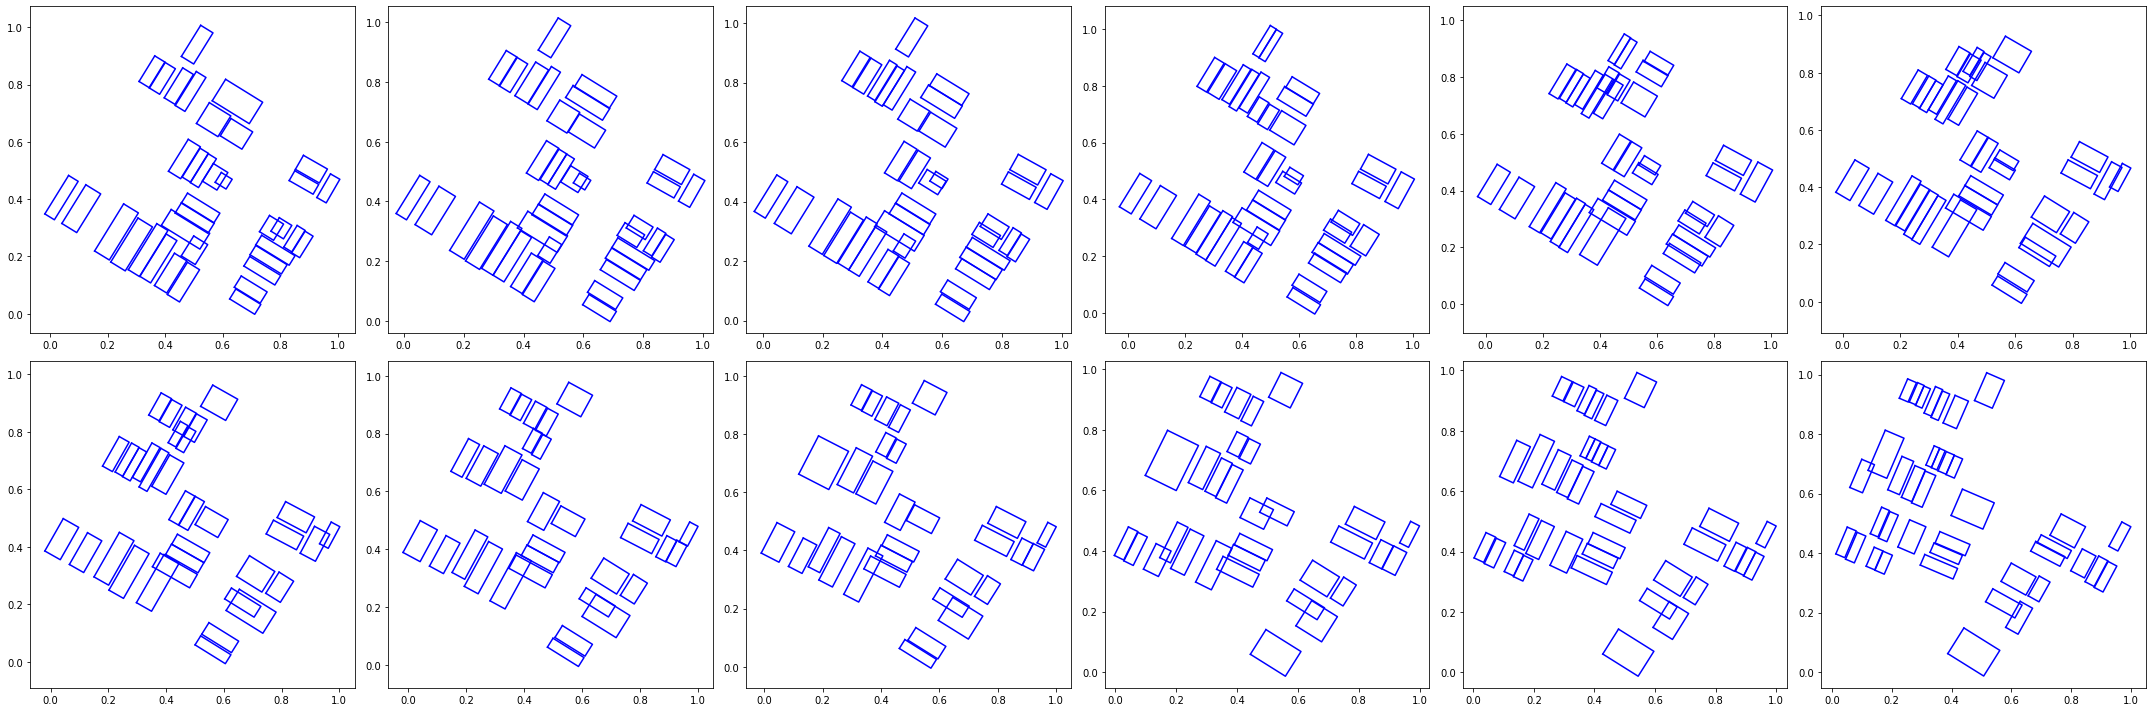

In [ ]:
nta_A = 27
nta_B = 12

latent0 = latent_ori[nta_A]
latent1 = latent_ori[nta_B]

steps = [latent0]+[latent0 + x*(latent1-latent0) for x in torch.linspace(0.1, 0.8, steps=10)]+[latent1]
latent_steps = torch.stack(steps, dim=0)

P0 = torch.reshape(root_P_list[nta_A],(1,5))
P1 = torch.reshape(root_P_list[nta_B],(1,5))

p_steps = [P0]+[P0 + x*(P1-P0) for x in torch.linspace(0.1, 0.8, steps=10)]+[P1]
P_steps = torch.stack(p_steps, dim=0)

# root_P = torch.Tensor([[0.4, 0.6, 0.8, 0.9, -0.4]])
Box_Set_List = []
for i in range(12):
    P_list, I_list, Set_list = inference_final_set(P_steps[i],latent_steps[i:i+1], 20)
    Set_list = Set_list.detach().numpy()
    box_set = get_box_2(Set_list[:,:2],Set_list[:,2:])
    Box_Set_List.append(box_set)
plot_boxes2(Box_Set_List,2,6,0,1)
#plot_boxes3(Box_Set_List,12,a,28-b)

# folder = './figure/interpolation/'
# if not os.path.exists(folder):
#     os.makedirs(folder)
# for i in range(12):
#     draw_box_save(Box_Set_List[i], name = folder+str(i)+'.png')

In [ ]:
import imageio
images = []
filenames = glob.glob('latent_interpolation/6_9_*.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('interpolation_2.gif', images,duration=0.8)

## **Clustering**
This performs dimensionality reduction and clustering (e.g., GMM, DBSCAN) on the latent space.

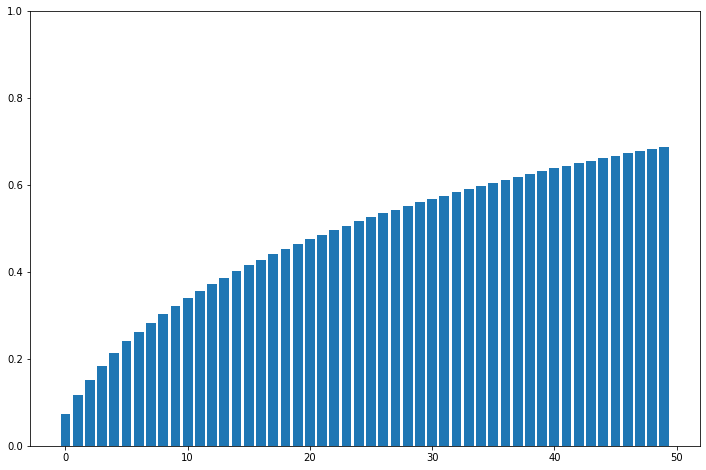

0.5159389609930333
0.6879064358249972


In [ ]:
sc = StandardScaler()
latentS = sc.fit_transform(torch.reshape(latent_ori,(45000,512)))

pca = PCA(n_components=50)
city_layout = pca.fit_transform(latentS)
plt.figure(figsize=(12,8))
plt.bar(np.arange(50),pca.explained_variance_ratio_.cumsum())
plt.ylim([0,1])
plt.show()

print(np.sum(pca.explained_variance_ratio_[:25]))
print(np.sum(pca.explained_variance_ratio_))

In [ ]:
layouts = pd.read_csv(path+'city_layouts_with_clustering.csv',index_col=0)
layouts.head()

,index,x,y,zipcode,nta,gmm
0,26489,9.991029e+05,235735.892554,10027,Central Harlem North-Polo Grounds,4
1,41270,9.834253e+05,203571.228461,10012,SoHo-TriBeCa-Civic Center-Little Italy,10
2,35657,9.898435e+05,214944.631124,10036,Midtown-Midtown South,3
3,18133,9.985651e+05,221002.182447,10028,Yorkville,0
4,16208,1.001484e+06,229830.613688,10035,East Harlem North,7


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=50.0)

latents = pd.DataFrame(city_layout)
latents['latent_index'] = latents.index
latents['cluster'] = layouts.gmm

latent_sample = latents.sample(frac=0.2)

X_tsne = tsne.fit_transform(latent_sample.iloc[:,:20])
X_tsne_data = np.vstack((X_tsne.T,latent_sample.latent_index,latent_sample.cluster)).T
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2','latent_index','cluster'])
df_tsne.head()

,Dim1,Dim2,latent_index,cluster
0,25.692099,-22.916267,32532.0,7.0
1,-1.493457,2.024677,20536.0,6.0
2,43.469940,-22.907495,29457.0,9.0
3,32.713810,22.409182,31065.0,7.0
4,-43.584351,23.248951,29326.0,4.0


In [ ]:
df_tsne.head()

,Dim1,Dim2,latent_index,cluster
0,25.692099,-22.916267,32532.0,7.0
1,-1.493457,2.024677,20536.0,6.0
2,43.469940,-22.907495,29457.0,9.0
3,32.713810,22.409182,31065.0,7.0
4,-43.584351,23.248951,29326.0,4.0


In [ ]:
df_tsne.to_csv('city_tsne.csv')

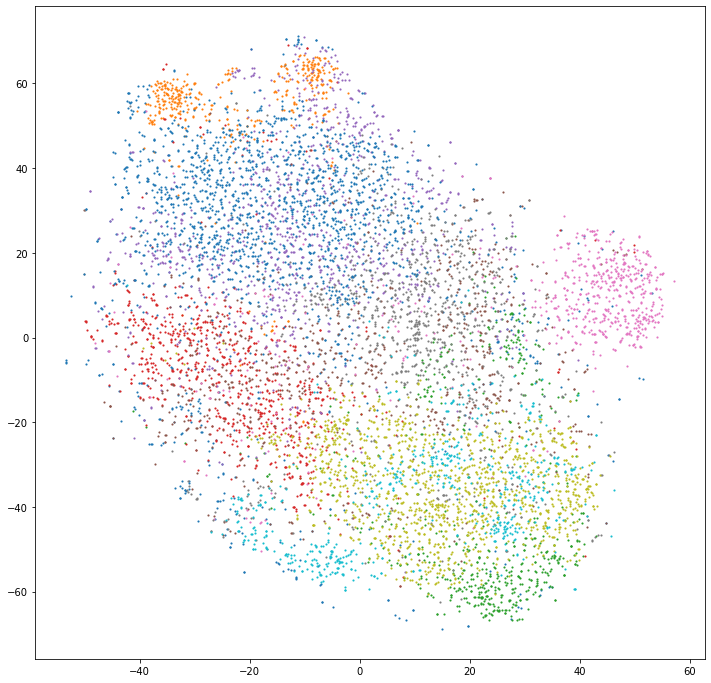

In [ ]:
fig = plt.figure(1, figsize=(12,12))
for i in range(11):
  plt.scatter(df_tsne[df_tsne.cluster==i]['Dim1'],
              df_tsne[df_tsne.cluster==i]['Dim2'],label=i,marker='.',s=5)

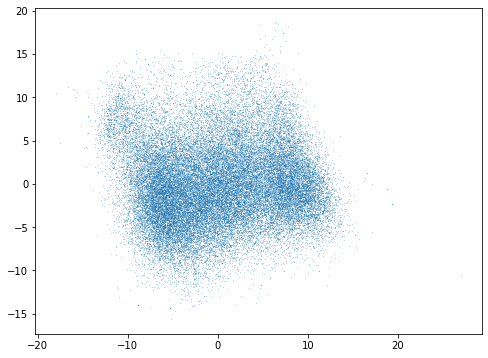

In [ ]:
city_layout = pd.DataFrame(city_layout)

fig = plt.figure(1, figsize=(8, 6))
plt.scatter(np.array(city_layout[0]), np.array(city_layout[1]),marker=".",s=0.05)
plt.show()

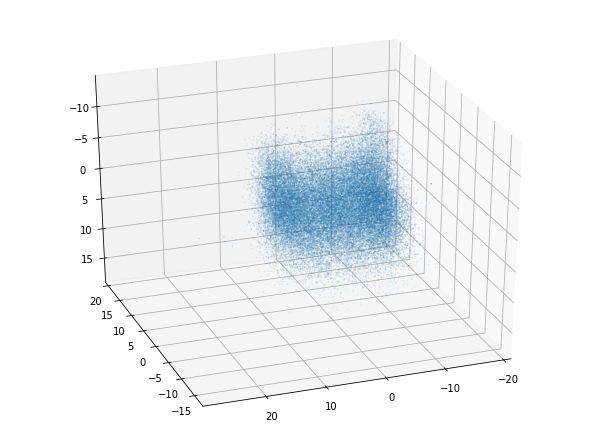

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(np.array(city_layout[0]),
          np.array(city_layout[1]),
          np.array(city_layout[2]),marker='.',s=0.05)

In [ ]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(gmm.means_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [ ]:
n_clusters=np.arange(4, 14)
bics=[]
bics_err=[]
iterations=10
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=1,tol=1e-3,max_iter=50).fit(city_layout.iloc[:,:50])
        tmp_bic.append(gmm.bic(city_layout.iloc[:,:50]))
    val=np.mean(SelBest(np.array(tmp_bic), 1))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)
    print('Cluster {} done...'.format(n))

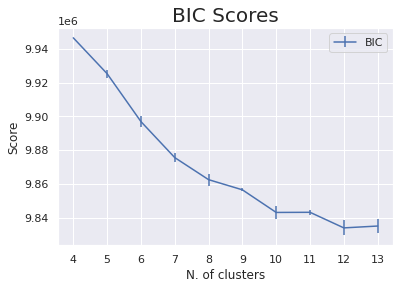

In [ ]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

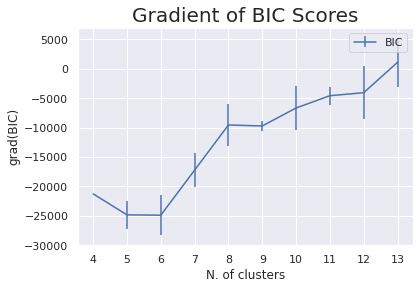

In [ ]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

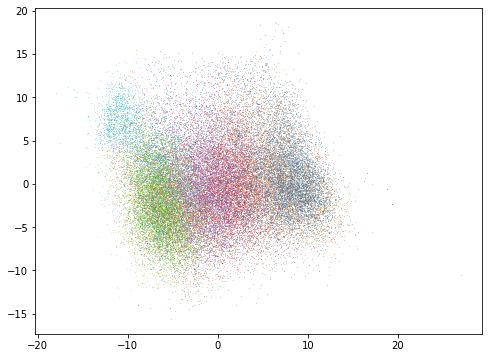

In [ ]:
# GMM with 50% explainability
n = 11
gm = GaussianMixture(n_components=n).fit(city_layout.iloc[:,:50])
city_layout['labels'] = 0
city_layout['labels'] = gm.predict(city_layout.iloc[:,:50])

fig = plt.figure(1, figsize=(8, 6))
for i in range(11):
  plt.scatter(np.array(city_layout[city_layout.labels==i][0]), np.array(city_layout[city_layout.labels==i][1]),label=i,marker=".",s=0.05)
# plt.legend()
plt.show()

In [ ]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)

for t in range(11):
  fig = plt.figure(1, figsize=(16,10))
  plt.scatter(np.array(city_layout[city_layout.labels!=t][0]), np.array(city_layout[city_layout.labels!=t][1]),c='grey',alpha=0.2,marker=".",s=1)
  plt.scatter(np.array(city_layout[city_layout.labels==t][0]), np.array(city_layout[city_layout.labels==t][1]),c=viridis(t/11),marker=".",s=5)
  plt.xlim((-20,20))
  plt.ylim((-15,20))
  plt.savefig('city_layout_analysis/gmm/{}.png'.format(t))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
city_layouts['gmm'] = 0
city_layouts['gmm'] = city_layout['labels']

In [ ]:
len(city_layouts)

45000

In [ ]:
city_layouts.head()

,index,x,y,zipcode,nta,gmm
0,26489,9.991029e+05,235735.892554,10027,Central Harlem North-Polo Grounds,4
1,41270,9.834253e+05,203571.228461,10012,SoHo-TriBeCa-Civic Center-Little Italy,10
2,35657,9.898435e+05,214944.631124,10036,Midtown-Midtown South,3
3,18133,9.985651e+05,221002.182447,10028,Yorkville,0
4,16208,1.001484e+06,229830.613688,10035,East Harlem North,7


In [ ]:
city_layouts.to_csv('city_layout_analysis/city_layouts_with_clustering.csv')

## **Pair evaluation | Do not run**
This generates the city layout pairs for human evaluation on Qualtrics. This can be ignored.

In [ ]:
def rotate_xy_2(p, sin, cos, center):
    x_ = (p[:,0:1]-center[:,0:1])*cos-(p[:,1:2]-center[:,1:2])*sin+center[:,0:1]
    y_ = (p[:,0:1]-center[:,0:1])*sin+(p[:,1:2]-center[:,1:2])*cos+center[:,1:2]
    return np.hstack((x_, y_))

def get_box_2(P, F):
    ld = np.hstack((P[:,0:1]-F[:,0:1]/2, P[:,1:2]-F[:,1:2]/2))
    rd = np.hstack((P[:,0:1]+F[:,0:1]/2, P[:,1:2]-F[:,1:2]/2))
    ru = np.hstack((P[:,0:1]+F[:,0:1]/2, P[:,1:2]+F[:,1:2]/2))
    lu = np.hstack((P[:,0:1]-F[:,0:1]/2, P[:,1:2]+F[:,1:2]/2))
    sinO = np.sin(F[:,2:3])
    cosO = np.cos(F[:,2:3])

    ld_r = rotate_xy_2(ld, sinO, cosO, P)
    rd_r = rotate_xy_2(rd, sinO, cosO, P)
    ru_r = rotate_xy_2(ru, sinO, cosO, P)
    lu_r = rotate_xy_2(lu, sinO, cosO, P)
    if(len(P)>0):
        box_r = np.hstack((ld_r, rd_r, ru_r, lu_r)).reshape(len(P), -1, 2)
    else:
        box_r = []
    return box_r

def draw_polygon_c(pc, txt, center, color):
    X, Y= pc[:, 0], pc[:,1]
    plt.plot(X, Y, c=color)
    plt.plot([X[-1],X[0]], [Y[-1],Y[0]], c=color)
    # if(txt):
    #     plt.annotate(txt, center, size=8)

def draw_box(box, txt, center, color):
    for i, p in enumerate(box):
        c = 'b' if color[i] else 'r'
        draw_polygon_c(p, txt[i], center[i], c)

def plot_boxes(samples, label, center, color, n, m, save=True, savename='pclouds'):
    fig = plt.figure(figsize=(10,5))
    fig.set_tight_layout(True)
    # for i in range(n):
    #     for j in range(m):
    idx = 0
    ax = fig.add_subplot(1,2,1)
    draw_box(samples[idx], label[idx], center[idx], color[idx])  

    idx = 2
    ax = fig.add_subplot(1,2,2)
    draw_box(samples[idx], label[idx], center[idx], color[idx])  

    if save:
        plt.savefig(savename)
    plt.show()

In [ ]:
def plot_box(train_index1, train_index2, savename):

  box_list = []
  center_list = []
  txt_list = []
  color_list = []

  for train_index in [train_index1, train_index2]:
    batch = train_index//50
    batch_num = train_index%50

    for i,(X, I_list, Feature, Node_is_leaf) in enumerate(train_loader, 0):
        if(i==batch):
            break

    X = X.squeeze(0)
    Feature = Feature.squeeze(0)
    Node_is_leaf = Node_is_leaf.squeeze(0)
    X = X.float()
    Feature = Feature.float()

    Feature_New = model.encode(X, Feature, I_list)
    X_r, X_ab_xy, X_ab_xy_r, Feature_r, Loss_P, Loss_Leaf, Num, _, _ = model.decode(X, Node_is_leaf, Feature_New, I_list)


    X_ab_xy = X_ab_xy.detach().numpy()
    X_ab_xy_r = X_ab_xy_r.detach().numpy()

    N = 32 #change num_boxes
    N_total = 2*N-1
    X_tree0 = X_ab_xy[N_total*batch_num:N_total*(batch_num+1),:2]
    X_tree0_r = X_ab_xy_r[N_total*batch_num:N_total*(batch_num+1),:2]

    Feature_tree0 = X_ab_xy[N_total*batch_num:N_total*(batch_num+1),2:]
    Feature_tree0_r = X_ab_xy_r[N_total*batch_num:N_total*(batch_num+1),2:]

    n = 1
    node_index = np.arange(N)
    color = np.zeros(len(node_index))
    P = X_tree0[node_index,:2]
    F = Feature_tree0[node_index]
    box = get_box_2(P,F)
    box_list.append(box)
    center_list.append(P)
    txt_list.append(node_index)
    color_list.append(color)  

    P = X_tree0_r[node_index,:2]
    F = Feature_tree0_r[node_index]
    box = get_box_2(P,F)
    box_list.append(box)
    center_list.append(P)
    txt_list.append(node_index)
    color_list.append(color)

  plot_boxes(box_list, txt_list, center_list, color_list, n, 1, savename=savename)

In [ ]:
city = pd.read_csv(path+'city_layouts_with_clustering.csv',index_col=0)
city.head()

,index,x,y,zipcode,nta,dbscan,gmm
0,26489,9.991029e+05,235735.892554,10027,Central Harlem North-Polo Grounds,5,0
1,41270,9.834253e+05,203571.228461,10012,SoHo-TriBeCa-Civic Center-Little Italy,0,3
2,35657,9.898435e+05,214944.631124,10036,Midtown-Midtown South,0,3
3,18133,9.985651e+05,221002.182447,10028,Yorkville,0,3
4,16208,1.001484e+06,229830.613688,10035,East Harlem North,0,4


In [ ]:
# select unique building clusters for evaluation
samples = []
for i in range(17):
  for j in range(5):
    #print(i,j)
    try:
      b = np.random.choice(np.array(city[(city.dbscan==i)&(city.gmm==j)]['index']),size=2)
      samples.extend(b)
    except:
      continue

In [ ]:
# pair up samples
pairs = []
for i in range(50):
  pairs.append(np.random.choice(samples,size=2,replace=False))

In [ ]:
for i in pairs:
  plot_box(i[0],i[1],savename='new_pair_evaluation/{}_{}.png'.format(i[0],i[1]))

## **Similarity calculation**
This calculates the cosine similarity of two latent spaces. It also contains the code for comparing the city layout similarity as calculated by latent space cosine similarity, compared to human evaluation.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import re
sc = StandardScaler()

In [8]:
def cosine(set1,set2):
  a = latent_ori[set1].reshape(1,-1)
  b = latent_ori[set2].reshape(1,-1)
  return cosine_similarity(a,b)[0][0]

In [9]:
filenames = [os.path.basename(x) for x in glob.glob('new_pair_evaluation/*.png')]
len(filenames)

50

In [10]:
city_layouts['index'].astype('int')
city_layouts.describe()

,index,x,y,zipcode
count,45000.000000,4.500000e+04,45000.000000,45000.000000
mean,22913.371378,9.922975e+05,220123.652008,10004.923156
std,13233.275541,6.622505e+03,14359.993190,483.550857
min,0.000000,9.712167e+05,188611.233228,0.000000
25%,11457.750000,9.866760e+05,207667.501399,10013.000000
50%,22905.500000,9.915611e+05,219103.414773,10024.000000
75%,34371.250000,9.982748e+05,230755.007969,10031.000000
max,45846.000000,1.010017e+06,259194.686822,10463.000000


In [11]:
pairs = []
for file in filenames:
  a = re.search(r'(?<=_)\w+', file)
  b = re.search(r'\w+(?=_)', file)
  set1 = city_layouts[city_layouts['index']==int(b[0])].index[0]
  set2 = city_layouts[city_layouts['index']==int(a[0])].index[0]

  score = cosine(set1,set2)
  pairs.append([int(b[0]),int(a[0]),score])

In [12]:
pairs.sort()
np.max([i[2] for i in pairs]) - np.min([i[2] for i in pairs])

0.3735472

In [13]:
results = pd.read_csv(path+'results.csv',header=None)
results = results.transpose()
results['avg'] = results.mean(axis=1)/10.0
results['cosine'] = [i[2] for i in pairs]
results.head()

,0,1,2,3,4,5,6,7,avg,cosine
0,5,4,5,5,5,4,5,5,0.475,0.489011
1,5,4,5,5,5,4,5,5,0.475,0.489011
2,3,3,4,3,3,3,4,3,0.325,0.335757
3,6,6,7,6,6,6,7,6,0.625,0.557627
4,7,8,7,7,7,8,7,7,0.725,0.615223


In [14]:
for i in range(8):
  results['norm_{}'.format(i)] = results[i]/np.linalg.norm(results[i])
  
results['norm_avg'] = results.iloc[:,10:].mean(axis=1)/10.0
results['norm_cosine'] = results['cosine']/np.linalg.norm(results['cosine'])

std_score=np.mean(pd.DataFrame(sc.fit_transform(results.iloc[:,:8])),axis=1)

In [15]:
# conver to binary if above mean
results['cosine_b'] = [1 if results.iloc[i,9] > np.mean(results.cosine) else 0 for i in range(50)]
results['avg_b'] = [1 if results.iloc[i,8] > np.mean(results.avg) else 0 for i in range(50)]

# conver to binary if above mean + standard deviation
results['cosine_c'] = [1 if results.iloc[i,9] > (np.mean(results.cosine)+np.std(results.cosine)) else 0 for i in range(50)]
results['avg_c'] = [1 if results.iloc[i,8] > (np.mean(results.avg)+np.std(results.avg)) else 0 for i in range(50)]

# conver to binary if above mean - standard deviation
results['cosine_d'] = [1 if results.iloc[i,9] > (np.mean(results.cosine)-np.std(results.cosine)) else 0 for i in range(50)]
results['avg_d'] = [1 if results.iloc[i,8] > (np.mean(results.avg)-np.std(results.avg)) else 0 for i in range(50)]

In [16]:
results.describe()

,0,1,2,3,4,5,6,7,avg,cosine,norm_0,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6,norm_7,norm_avg,norm_cosine,cosine_b,avg_b,cosine_c,avg_c,cosine_d,avg_d
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000
mean,4.960000,4.840000,5.000000,5.020000,4.960000,4.840000,5.000000,5.020000,0.495500,0.508267,0.138312,0.137226,0.137620,0.137393,0.138312,0.137226,0.137620,0.137393,0.013764,0.139294,0.500000,0.480000,0.180000,0.14000,0.840000,0.920000
std,1.068281,1.218229,1.195229,1.237014,1.068281,1.218229,1.195229,1.237014,0.074177,0.090067,0.029790,0.034540,0.032898,0.033856,0.029790,0.034540,0.032898,0.033856,0.002060,0.024683,0.505076,0.504672,0.388088,0.35051,0.370328,0.274048
min,3.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,0.325000,0.323607,0.083657,0.056705,0.055048,0.082107,0.083657,0.056705,0.055048,0.082107,0.009019,0.088687,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,0.450000,0.451375,0.111542,0.113410,0.110096,0.109476,0.111542,0.113410,0.110096,0.109476,0.012509,0.123703,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.475000,0.507254,0.139428,0.141762,0.137620,0.136845,0.139428,0.141762,0.137620,0.136845,0.013240,0.139017,0.500000,0.000000,0.000000,0.00000,1.000000,1.000000
75%,6.000000,5.750000,6.000000,6.000000,6.000000,5.750000,6.000000,6.000000,0.550000,0.558977,0.167313,0.163026,0.165145,0.164214,0.167313,0.163026,0.165145,0.164214,0.015264,0.153192,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000
max,7.000000,8.000000,8.000000,8.000000,7.000000,8.000000,8.000000,8.000000,0.725000,0.697154,0.195199,0.226819,0.220193,0.218952,0.195199,0.226819,0.220193,0.218952,0.020157,0.191060,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [17]:
# correlation of raw scores
np.corrcoef(results.avg,results.cosine)

array([[1.        , 0.43040537],
       [0.43040537, 1.        ]])

In [18]:
# correlation of standardized scores
np.corrcoef(std_score,results.cosine)

array([[1.        , 0.43104738],
       [0.43104738, 1.        ]])

In [22]:
from sklearn.metrics import r2_score
r2_score(results.avg,results.cosine)

-0.4593209679220236

In [19]:
m, b = np.polyfit(std_score,results.cosine,1)

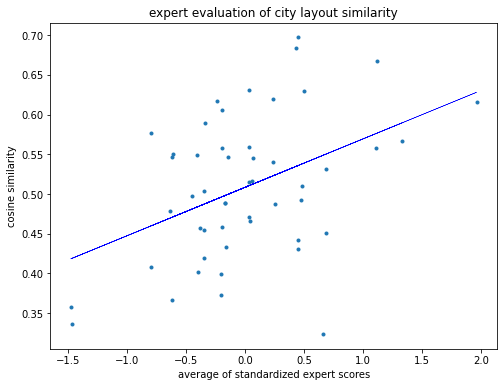

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(std_score,results.cosine,marker='.')
plt.plot(std_score, m*std_score + b,c='blue',linewidth=.5)
plt.ylabel("cosine similarity")
plt.xlabel("average of standardized expert scores")
plt.title("expert evaluation of city layout similarity")
plt.show()

In [ ]:
# percentage correct if taking mean as threshold
wrong = 0
for i in range(50):
  if results.iloc[i,20] != results.iloc[i,21]:
    wrong += 1
print('% correct - mean as threshold:', round(1-(wrong/50.0),2))

# percentage correct if taking mean+std as threshold
wrong = 0
for i in range(50):
  if results.iloc[i,20] != results.iloc[i,23]:
    wrong += 1
print('% correct - mean+std as threshold:', round(1-(wrong/50.0),2))

# percentage correct if taking mean-std as threshold
wrong = 0
for i in range(50):
  if results.iloc[i,20] != results.iloc[i,25]:
    wrong += 1
print('% correct - mean-std as threshold:', round(1-(wrong/50.0),2))

% correct - mean as threshold: 0.66
% correct - mean+std as threshold: 0.56
% correct - mean-std as threshold: 0.54


## **Spatial analysis**
Mapping latent space analysis (e.g., clustering) onto the spatial map of NYC.

In [ ]:
def draw_polygon(xyz_foot):
    x = xyz_foot[:,0]
    y = xyz_foot[:,1]
    z = xyz_foot[:,2]

    ax = plt.subplot(projection='3d')
    ax.axis('off')
    ax.scatter(x, y, z, c='g',alpha=1)
    ax.plot(x, y, z, c='b')
    ax.plot([x[-1],x[0]], [y[-1],y[0]], [z[-1],z[0]], c='r')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [ ]:
# visualize distribution of clusters by zipcode level
zipcodes = buildings[buildings.zipcode>100].zipcode.unique()
top_dbscan = []
for zipcode in zipcodes:
  clusters = []
  for i in range(17):
    clusters.append(len(buildings[(buildings.zipcode==zipcode)&(buildings.dbscan==i)]))
  top_dbscan.append(np.argmax(clusters[1:]))
  plt.bar(np.arange(16),clusters[1:])
  plt.title('building clusters in {}'.format(zipcode))
  plt.show()

In [ ]:
b100 = buildings.groupby(['zipcode']).agg({'dbscan':'mean','gmm':'mean','train_index':'count'})
b100.rename(columns={'train_index':'count','dbscan':'dbscan_mean'},inplace=True)
b100 = b100.iloc[2:,:]
b100['dbscan_top'] = top_dbscan

## **Geometric Clustering**

In [ ]:
geo = pd.read_csv(path+'geometric_features.csv',index_col=0)
layouts = pd.read_csv(path+'city_layouts_with_clustering.csv',index_col=0)
geo = geo.merge(layouts[['index','nta','gmm']],left_on='index',right_on='index')
geo.head()

,index,x,y,zipcode,area,perimeter,avg_lw,std_lw,range_lw,std_rot,avg_rot,std_area,mean_area,range_area,std_perimeter,mean_perimeter,range_perimeter,nta,gmm
0,26489,9.991029e+05,235735.892554,10027.0,0.215197,11.512384,0.612699,0.746051,3.236755,0.001073,-0.568640,0.004308,0.006725,0.017902,0.095110,0.359762,0.351048,Central Harlem North-Polo Grounds,4
1,41270,9.834253e+05,203571.228461,10012.0,0.161158,8.267206,1.439193,1.032524,3.526648,0.101728,-0.447973,0.006640,0.005036,0.028439,0.154204,0.258350,0.604909,SoHo-TriBeCa-Civic Center-Little Italy,10
2,35657,9.898435e+05,214944.631124,10036.0,0.191622,10.888162,1.685483,1.243508,3.879776,0.001029,-0.556468,0.003577,0.005988,0.014085,0.097791,0.340255,0.342788,Midtown-Midtown South,3
3,18133,9.985651e+05,221002.182447,10028.0,0.226602,9.853267,1.231770,1.466105,4.746412,0.004152,-0.510148,0.012274,0.007081,0.055819,0.189777,0.307915,0.812552,Yorkville,0
4,16208,1.001484e+06,229830.613688,10035.0,0.236437,11.239347,0.767389,0.729433,2.682584,0.004699,-0.622231,0.006889,0.007389,0.026191,0.126585,0.351230,0.486740,East Harlem North,7


In [ ]:
df_tsne = pd.read_csv('city_tsne.csv',index_col=0)
df_tsne = df_tsne.merge(geo.iloc[:,:17],left_on='latent_index',right_on='index')
df_tsne.drop(columns=['x','y','index','zipcode','std_lw','range_lw','mean_area','range_area','mean_perimeter','range_perimeter'],inplace=True)
df_tsne = df_tsne.round(3)
df_tsne.to_csv('city_tsne_2.csv')
df_tsne

,Dim1,Dim2,latent_index,cluster,area,perimeter,avg_lw,std_rot,avg_rot,std_area,std_perimeter
0,-6.175,54.187,30440.0,4.0,0.266,11.360,0.461,0.002,-0.654,0.018,0.204
1,22.395,-24.069,29070.0,8.0,0.275,10.359,1.003,0.002,-0.457,0.016,0.223
2,38.028,-33.353,17906.0,8.0,0.252,10.721,1.766,0.073,-0.493,0.011,0.188
3,-22.981,39.027,20966.0,4.0,0.172,9.875,0.609,0.002,-0.463,0.004,0.097
4,39.430,-52.868,28680.0,2.0,0.197,9.835,1.182,0.012,-0.498,0.006,0.127
...,...,...,...,...,...,...,...,...,...,...,...
8830,19.004,-58.815,9646.0,2.0,0.306,12.584,0.565,0.302,-0.462,0.010,0.176
8831,-1.405,19.373,41709.0,7.0,0.225,10.435,1.130,0.012,-0.537,0.006,0.135
8832,-2.657,-30.303,21379.0,8.0,0.192,9.204,0.961,0.154,-0.433,0.006,0.143
8833,-18.497,17.548,40819.0,4.0,0.167,10.493,0.612,0.003,-0.508,0.005,0.113


In [ ]:
cluster_type = {0:['very sparse','mostly regular footprints','uneven grain'],
                1:['very dense','irregular footprints','very even grain'],
                2:['sparse','irregular footprints','uneven grain'],
                3:['dense','regular footprints','mostly even grain'],
                4:['moderate density','regular footprints','mostly even grain'],
                5:['moderate density','regular footprints','mostly even grain'],
                6:['very sparse','mostly regular footprints','very even grain'],
                7:['dense','regular footprints','uneven grain'],
                8:['moderate density','regular footprints','mostly even grain'],
                9:['sparse','irregular footprints','mostly even grain'],
                10:['moderate density','mostly regular footprints','very even grain']}

In [ ]:
[cluster_type[i][0] for i in cluster_type]

['very sparse',
 'very dense',
 'sparse',
 'dense',
 'moderate density',
 'moderate density',
 'very sparse',
 'dense',
 'moderate density',
 'sparse',
 'moderate density']

In [ ]:
geoG = geo.groupby(['gmm']).agg({'area':'mean','perimeter':'mean','std_area':'mean','std_perimeter':'mean','avg_lw':'mean','avg_rot':'mean','std_rot':'mean'})
geoG.columns = ['area','perimeter','std. dev. area','std. dev. perimeter','avg length:width ratio','avg building rotation','std. dev. building rotation']
geoG['building density'] = [cluster_type[i][0] for i in cluster_type]
geoG['building regularity'] = [cluster_type[i][1] for i in cluster_type]
geoG['evenness'] = [cluster_type[i][1] for i in cluster_type]
geoG = geoG.round(3)
geoG.to_csv('geoCluster.csv')
# geoG.style.bar(color='#d65f5f')
geoG

,area,perimeter,std. dev. area,std. dev. perimeter,avg length:width ratio,avg building rotation,std. dev. building rotation,building density,building regularity,evenness
gmm,,,,,,,,,,
0,0.197,9.534,0.008,0.150,1.185,-0.378,0.097,very sparse,mostly regular footprints,mostly regular footprints
1,0.254,12.599,0.006,0.102,0.514,-0.519,0.004,very dense,irregular footprints,irregular footprints
2,0.205,10.119,0.008,0.138,1.286,-0.479,0.039,sparse,irregular footprints,irregular footprints
3,0.219,10.468,0.008,0.142,1.148,-0.440,0.038,dense,regular footprints,regular footprints
4,0.213,10.427,0.007,0.136,1.126,-0.473,0.027,moderate density,regular footprints,regular footprints
5,0.216,10.309,0.007,0.138,1.140,0.027,0.121,moderate density,regular footprints,regular footprints
6,0.197,9.880,0.007,0.133,1.200,-0.414,0.102,very sparse,mostly regular footprints,mostly regular footprints
7,0.227,10.831,0.008,0.139,1.040,-0.475,0.023,dense,regular footprints,regular footprints
8,0.216,10.593,0.007,0.133,1.087,-0.494,0.021,moderate density,regular footprints,regular footprints


In [ ]:
geo2 = geo[~geo.nta.isin(['0','park-cemetery-etc-Manhattan'])]
geoNTA = geo2.groupby(['nta']).agg({'area':'mean','perimeter':'mean','std_area':'mean','std_perimeter':'mean','avg_lw':'mean','avg_rot':'mean','std_rot':'mean'})
geoNTA.loc['Manhattan'] = list(geoNTA.mean())
geoNTA.columns = ['area','perimeter','std. dev. area','std. dev. perimeter','avg length:width ratio','avg building rotation','std. dev. building rotation']
geoNTA = geoNTA.round(3)
geoNTA.to_csv('geoNTA.csv')
geoNTA

,area,perimeter,std. dev. area,std. dev. perimeter,avg length:width ratio,avg building rotation,std. dev. building rotation
nta,,,,,,,
Battery Park City-Lower Manhattan,0.215,10.405,0.008,0.137,1.138,-0.439,0.047
Central Harlem North-Polo Grounds,0.212,10.389,0.007,0.135,1.129,-0.426,0.043
Central Harlem South,0.215,10.464,0.007,0.135,1.113,-0.414,0.049
Chinatown,0.215,10.515,0.007,0.134,1.115,-0.431,0.041
Clinton,0.212,10.436,0.007,0.133,1.119,-0.422,0.046
East Harlem North,0.214,10.432,0.008,0.136,1.108,-0.425,0.044
East Harlem South,0.215,10.498,0.007,0.134,1.145,-0.431,0.042
East Village,0.216,10.547,0.007,0.134,1.094,-0.424,0.042
Gramercy,0.216,10.482,0.008,0.135,1.149,-0.429,0.037
